# Example: Aluminum WR-28 Waveguide

- Calculate the effective conductivity of aluminum using the Gradient Model for different surface roughnesses.
- Use these values to calculate the attenuation of a WR-28 waveguide.
- Compare HFSS to theory.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import skrf as rf
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

# https://github.com/garrettj403/GradientModel
import sys
sys.path.append("..")
import gradientmodel as gm

# https://github.com/garrettj403/Waveguide
from waveguide import conductor_loss, np2db

# https://github.com/garrettj403/SciencePlots
plt.style.use(['science', 'notebook'])

# Waveguide Properties

In [3]:
# Dimensions
a, b = 280*sc.mil, 140*sc.mil
length = 10*sc.centi

In [4]:
# DC conductivity, S/m
conductivity_0 = 38000000

# Smooth Waveguide

In [5]:
# From theory
frequency = np.linspace(21.1, 42, 210) * sc.giga
attenuation_theory = np2db(conductor_loss(frequency, conductivity_0, a, b))

In [6]:
# From HFSS
hfss_results = rf.Network("hfss/WR28-Waveguide_10cm-aluminum.s2p")
attenuation_hfss = -hfss_results.s_db[:,1,0] / length

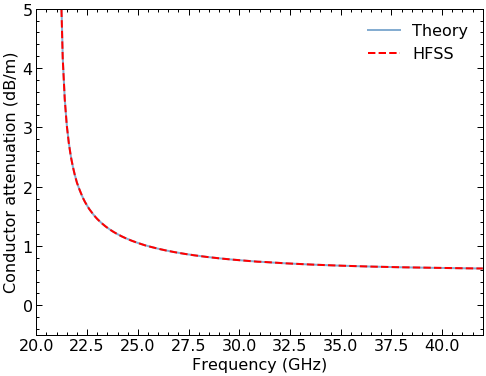

In [7]:
# Compare
fig, ax = plt.subplots()
ax.plot(frequency/1e9, attenuation_theory, alpha=0.5, label="Theory")
ax.plot(hfss_results.f/1e9, attenuation_hfss, 'r--', label="HFSS")
plt.autoscale(enable=True, axis='x', tight=True)
ax.set_ylabel("Conductor attenuation (dB/m)")
ax.set_xlabel("Frequency (GHz)")
ax.set_ylim([-0.5, 5])
ax.legend();

Very close match!

# Gradient Model: Surface Impedance $Z_s$

In [8]:
# Frequency sweep for gradient model
frequency_gm = np.linspace(20, 45, 5) * sc.giga

# Gradient model: 0.1um surface roughness
surface_roughness1 = 100 * sc.nano
zs_gm1, conductivity_gm1, ur_gm1 = gm.rough_properties(frequency_gm, surface_roughness1, sigma0=conductivity_0)
fconductivity_gm1 = interp1d(frequency_gm, conductivity_gm1, kind='cubic')
fur_gm1 = interp1d(frequency_gm, ur_gm1, kind='cubic')

# Gradient model: 0.25um surface roughness
surface_roughness2 = 250 * sc.nano
zs_gm2, conductivity_gm2, ur_gm2 = gm.rough_properties(frequency_gm, surface_roughness2, sigma0=conductivity_0)
fconductivity_gm2 = interp1d(frequency_gm, conductivity_gm2, kind='cubic')
fur_gm2 = interp1d(frequency_gm, ur_gm2, kind='cubic')

# Gradient model: 0.5um surface roughness
surface_roughness3 = 0.5 * sc.micro
zs_gm3, conductivity_gm3, ur_gm3 = gm.rough_properties(frequency_gm, surface_roughness3, sigma0=conductivity_0)
fconductivity_gm3 = interp1d(frequency_gm, conductivity_gm3, kind='cubic')
fur_gm3 = interp1d(frequency_gm, ur_gm3, kind='cubic')

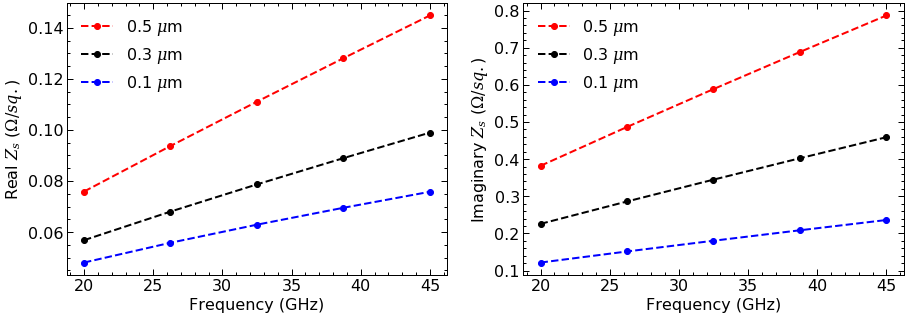

In [9]:
# Plot impedance
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,5))

# Real component
ax0.plot(frequency_gm/1e9, zs_gm3.real, 'ro--', label=r'{:.1f} $\mu$m'.format(surface_roughness3/sc.micro))
ax0.plot(frequency_gm/1e9, zs_gm2.real, 'ko--', label=r'{:.1f} $\mu$m'.format(surface_roughness2/sc.micro))
ax0.plot(frequency_gm/1e9, zs_gm1.real, 'bo--', label=r'{:.1f} $\mu$m'.format(surface_roughness1/sc.micro))
ax0.set_ylabel(r"Real $Z_s$ ($\Omega/sq.$)")
ax0.set_xlabel("Frequency (GHz)")
ax0.legend()

# Imaginary component
ax1.plot(frequency_gm/1e9, zs_gm3.imag, 'ro--', label=r'{:.1f} $\mu$m'.format(surface_roughness3/sc.micro))
ax1.plot(frequency_gm/1e9, zs_gm2.imag, 'ko--', label=r'{:.1f} $\mu$m'.format(surface_roughness2/sc.micro))
ax1.plot(frequency_gm/1e9, zs_gm1.imag, 'bo--', label=r'{:.1f} $\mu$m'.format(surface_roughness1/sc.micro))
ax1.set_ylabel(r"Imaginary $Z_s$ ($\Omega/sq.$)")
ax1.set_xlabel("Frequency (GHz)")
ax1.legend();

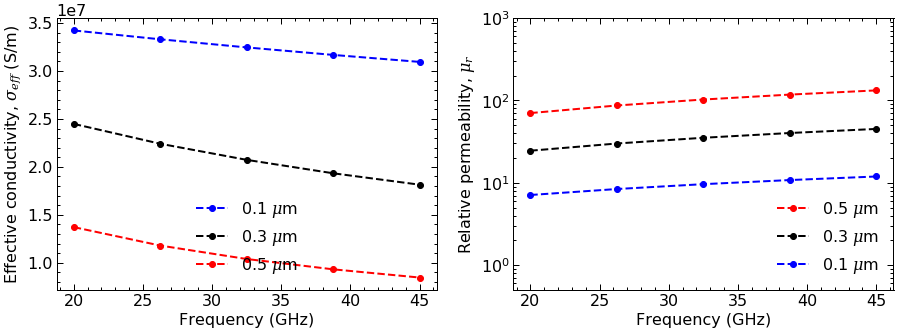

In [10]:
# Plot impedance
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,5))

# Plot conductivity
ax0.plot(frequency_gm/1e9, conductivity_gm1, 'bo--', label=r'{:.1f} $\mu$m'.format(surface_roughness1/sc.micro))
ax0.plot(frequency_gm/1e9, conductivity_gm2, 'ko--', label=r'{:.1f} $\mu$m'.format(surface_roughness2/sc.micro))
ax0.plot(frequency_gm/1e9, conductivity_gm3, 'ro--', label=r'{:.1f} $\mu$m'.format(surface_roughness3/sc.micro))
ax0.set_ylabel(r"Effective conductivity, $\sigma_{eff}$ (S/m)")
ax0.set_xlabel("Frequency (GHz)")
ax0.legend()

# Plot permeability
ax1.semilogy(frequency_gm/1e9, ur_gm3, 'ro--', label=r'{:.1f} $\mu$m'.format(surface_roughness3/sc.micro))
ax1.semilogy(frequency_gm/1e9, ur_gm2, 'ko--', label=r'{:.1f} $\mu$m'.format(surface_roughness2/sc.micro))
ax1.semilogy(frequency_gm/1e9, ur_gm1, 'bo--', label=r'{:.1f} $\mu$m'.format(surface_roughness1/sc.micro))
ax1.set_ylabel(r"Relative permeability, $\mu_r$")
ax1.set_xlabel("Frequency (GHz)")
ax1.set_ylim([0.5e0, 1e3])
ax1.legend();

In [11]:
# Polyfit for HFSS
p_zs_real_gm1 = np.polyfit(frequency_gm, zs_gm1.real, 2)
p_zs_real_gm2 = np.polyfit(frequency_gm, zs_gm2.real, 2)
p_zs_real_gm3 = np.polyfit(frequency_gm, zs_gm3.real, 2)
p_zs_imag_gm1 = np.polyfit(frequency_gm, zs_gm1.imag, 2)
p_zs_imag_gm2 = np.polyfit(frequency_gm, zs_gm2.imag, 2)
p_zs_imag_gm3 = np.polyfit(frequency_gm, zs_gm3.imag, 2)
p_ur_gm1 = np.polyfit(frequency_gm, ur_gm1, 2)
p_ur_gm2 = np.polyfit(frequency_gm, ur_gm2, 2)
p_ur_gm3 = np.polyfit(frequency_gm, ur_gm3, 2)

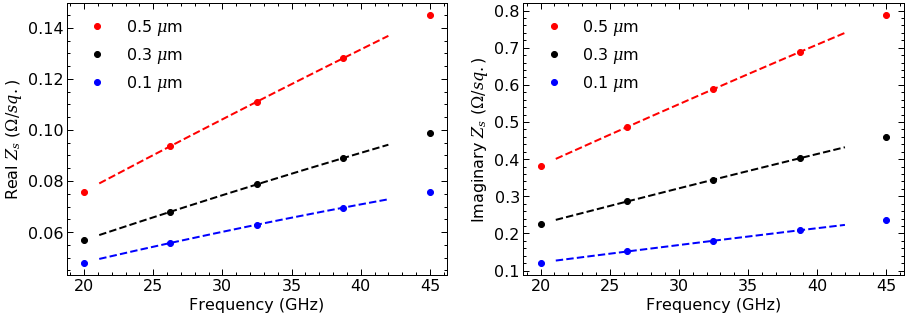

In [12]:
# Plot polyfit
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,5))

# Real component
ax0.plot(frequency_gm/1e9, zs_gm3.real, 'ro', label=r'{:.1f} $\mu$m'.format(surface_roughness3/sc.micro))
ax0.plot(frequency_gm/1e9, zs_gm2.real, 'ko', label=r'{:.1f} $\mu$m'.format(surface_roughness2/sc.micro))
ax0.plot(frequency_gm/1e9, zs_gm1.real, 'bo', label=r'{:.1f} $\mu$m'.format(surface_roughness1/sc.micro))
ax0.plot(frequency/1e9, np.polyval(p_zs_real_gm3, frequency), 'r--')
ax0.plot(frequency/1e9, np.polyval(p_zs_real_gm2, frequency), 'k--')
ax0.plot(frequency/1e9, np.polyval(p_zs_real_gm1, frequency), 'b--')
ax0.set_ylabel(r"Real $Z_s$ ($\Omega/sq.$)")
ax0.set_xlabel("Frequency (GHz)")
ax0.legend()

# Imaginary component
ax1.plot(frequency_gm/1e9, zs_gm3.imag, 'ro', label=r'{:.1f} $\mu$m'.format(surface_roughness3/sc.micro))
ax1.plot(frequency_gm/1e9, zs_gm2.imag, 'ko', label=r'{:.1f} $\mu$m'.format(surface_roughness2/sc.micro))
ax1.plot(frequency_gm/1e9, zs_gm1.imag, 'bo', label=r'{:.1f} $\mu$m'.format(surface_roughness1/sc.micro))
ax1.plot(frequency/1e9, np.polyval(p_zs_imag_gm3, frequency), 'r--')
ax1.plot(frequency/1e9, np.polyval(p_zs_imag_gm2, frequency), 'k--')
ax1.plot(frequency/1e9, np.polyval(p_zs_imag_gm1, frequency), 'b--')
ax1.set_ylabel(r"Imaginary $Z_s$ ($\Omega/sq.$)")
ax1.set_xlabel("Frequency (GHz)")
ax1.legend();

In [13]:
def print_poly(poly):
    fpower_max = len(poly) - 1
    string = ""
    for i, p in enumerate(poly):
        fpower = fpower_max - i
        if fpower != 0:
            string += "{:.4e}".format(p) + " * Freq^{:d} + ".format(fpower)
        else:
            string += "{:.4e}".format(p)
    print(string)

print("Surface impedance (Z_s):")
print("\n{:.1f} um surface roughness:".format(surface_roughness1/sc.micro))
print("\tReal:\t\t", end=""); print_poly(p_zs_real_gm1)
print("\tImaginary:\t", end=""); print_poly(p_zs_imag_gm1)
print("\tur:\t\t", end=""); print_poly(p_ur_gm1)
print("\n{:.1f} um surface roughness:".format(surface_roughness2/sc.micro))
print("\tReal:\t\t", end=""); print_poly(p_zs_real_gm2)
print("\tImaginary:\t", end=""); print_poly(p_zs_imag_gm2)
print("\tur:\t\t", end=""); print_poly(p_ur_gm2)
print("\n{:.1f} um surface roughness:".format(surface_roughness3/sc.micro))
print("\tReal:\t\t", end=""); print_poly(p_zs_real_gm3)
print("\tImaginary:\t", end=""); print_poly(p_zs_imag_gm3)
print("\tur:\t\t", end=""); print_poly(p_ur_gm3)

Surface impedance (Z_s):

0.1 um surface roughness:
	Real:		-6.2708e-24 * Freq^2 + 1.5146e-12 * Freq^1 + 2.0281e-02
	Imaginary:	-9.1992e-24 * Freq^2 + 5.1772e-12 * Freq^1 + 2.1676e-02
	ur:		-6.8352e-22 * Freq^2 + 2.3677e-10 * Freq^1 + 2.6457e+00

0.3 um surface roughness:
	Real:		-5.1230e-24 * Freq^2 + 2.0174e-12 * Freq^1 + 1.8520e-02
	Imaginary:	-1.5310e-23 * Freq^2 + 1.0324e-11 * Freq^1 + 2.5399e-02
	ur:		-2.6131e-21 * Freq^2 + 9.9119e-10 * Freq^1 + 5.7468e+00

0.5 um surface roughness:
	Real:		-4.6545e-24 * Freq^2 + 3.0615e-12 * Freq^1 + 1.6517e-02
	Imaginary:	-2.6448e-23 * Freq^2 + 1.7904e-11 * Freq^1 + 3.4601e-02
	ur:		-8.0740e-21 * Freq^2 + 3.0100e-09 * Freq^1 + 1.3296e+01


**Note:** In HFSS, select `Assign boundary > Impedance...` and then copy/paste these values into the dialog box.

# Rough Waveguide

In [14]:
# From perturbation theory using conductivity from Gradient Model
attenuation_perturbation_gm1 = np2db(conductor_loss(frequency, fconductivity_gm1(frequency), a, b))
attenuation_perturbation_gm2 = np2db(conductor_loss(frequency, fconductivity_gm2(frequency), a, b))
attenuation_perturbation_gm3 = np2db(conductor_loss(frequency, fconductivity_gm3(frequency), a, b))

In [15]:
# # From Lomakin et al
# attenuation_tlm_gm1 = np2db(gm.waveguide_propagation(frequency, a, b, fconductivity_gm1(frequency), fur_gm1(frequency), cond=conductivity_0)[0].real)
# attenuation_tlm_gm2 = np2db(gm.waveguide_propagation(frequency, a, b, fconductivity_gm2(frequency), fur_gm2(frequency), cond=conductivity_0)[0].real)
# attenuation_tlm_gm3 = np2db(gm.waveguide_propagation(frequency, a, b, fconductivity_gm3(frequency), fur_gm3(frequency), cond=conductivity_0)[0].real)


Note: This approach is based on a perturbation approach, so it ignores any changes to phase velocity. This is fine as long as the conductivity is high enough.

In [16]:
# From HFSS
hfss_results1 = rf.Network("hfss/WR28-Waveguide_10cm-aluminum-rough-100nm.s2p")
attenuation_hfss_gm1 = -hfss_results1.s_db[:,1,0] / length
hfss_results2 = rf.Network("hfss/WR28-Waveguide_10cm-aluminum-rough-500nm.s2p")
attenuation_hfss_gm2 = -hfss_results2.s_db[:,1,0] / length
hfss_results3 = rf.Network("hfss/WR28-Waveguide_10cm-aluminum-rough-1um.s2p")
attenuation_hfss_gm3 = -hfss_results3.s_db[:,1,0] / length

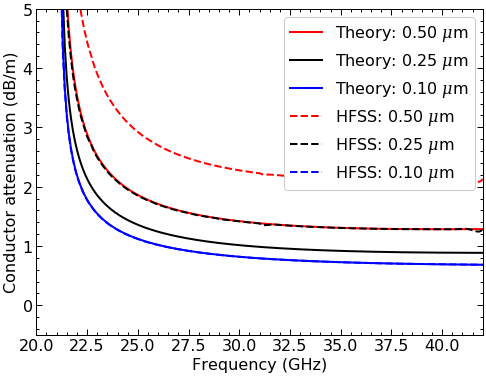

In [17]:
# Compare
fig, ax = plt.subplots()
ax.plot(frequency/1e9, attenuation_perturbation_gm3, 'r', label="Theory: {:.2f} $\mu$m".format(surface_roughness3/sc.micro))
ax.plot(frequency/1e9, attenuation_perturbation_gm2, 'k', label="Theory: {:.2f} $\mu$m".format(surface_roughness2/sc.micro))
ax.plot(frequency/1e9, attenuation_perturbation_gm1, 'b', label="Theory: {:.2f} $\mu$m".format(surface_roughness1/sc.micro))
# ax.plot(frequency/1e9, attenuation_tlm_gm3, 'r', label="Theory: {:.2f} $\mu$m".format(surface_roughness3/sc.micro))
# ax.plot(frequency/1e9, attenuation_tlm_gm2, 'k', label="Theory: {:.2f} $\mu$m".format(surface_roughness2/sc.micro))
# ax.plot(frequency/1e9, attenuation_tlm_gm1, 'b', label="Theory: {:.2f} $\mu$m".format(surface_roughness1/sc.micro))
ax.plot(hfss_results3.f/1e9, attenuation_hfss_gm3, 'r--', label="HFSS: {:.2f} $\mu$m".format(surface_roughness3/sc.micro))
ax.plot(hfss_results2.f/1e9, attenuation_hfss_gm2, 'k--', label="HFSS: {:.2f} $\mu$m".format(surface_roughness2/sc.micro))
ax.plot(hfss_results1.f/1e9, attenuation_hfss_gm1, 'b--', label="HFSS: {:.2f} $\mu$m".format(surface_roughness1/sc.micro))
plt.autoscale(enable=True, axis='x', tight=True)
ax.set_ylabel("Conductor attenuation (dB/m)")
ax.legend(frameon=True, framealpha=1)
ax.set_xlabel("Frequency (GHz)")
ax.set_ylim([-0.5, 5]);

Perturbation approach provides a reasonable value for conductor attenuation.